In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt


## Loading Data and Data Wrangling

In [2]:
cwd = os.getcwd()
adata = sc.read_h5ad(cwd+'/outs/240701_kinker_anndata.h5ad')
adata
adata.X = adata.X.astype(float)

## Dimensionality Reduction
- To reduce a large set of variables into a smaller set that retains most of the original information.
- Principal Component Analysis (PCA) ransforms correlated variables into a smaller number of uncorrelated variables.
- Valuable it can identify co-expressed gene modules, helps to group genes based on their co-variation, with components ranked by their explained variation.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


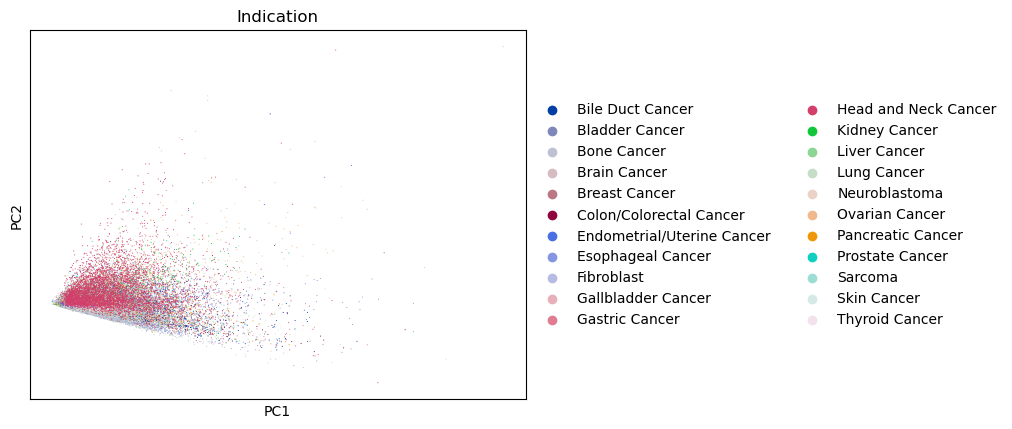

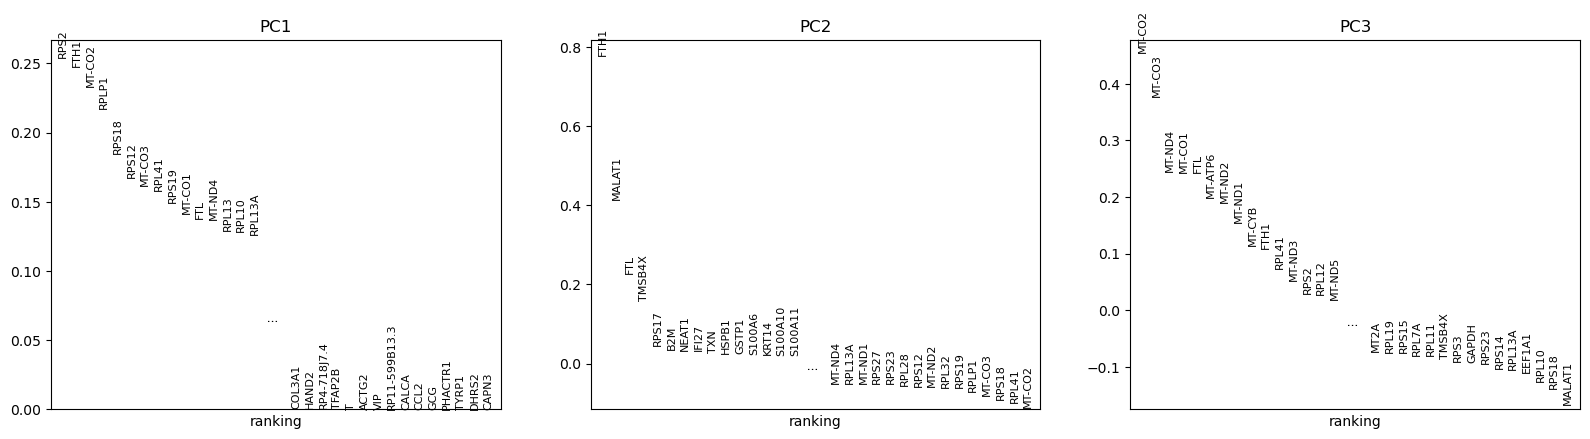

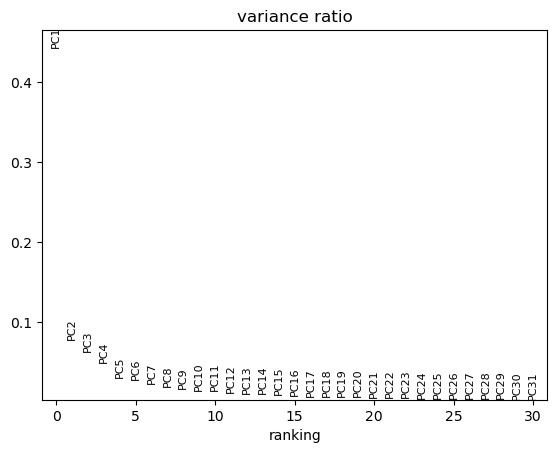

In [5]:
sc.pp.pca(adata, svd_solver='arpack')
sc.pl.pca_overview(adata, color='Indication')

- The initial plot reveals an unusually linear PC1, which accounts for the most variation in the dataset.
- The plot at the bottom illustrates that the first PC captures, majority of variation in the raw data, with only a few genes predominantly contributing to variation.
- Better to normalize data.

#### Normalization by size-factor
-  Counts can vary between identical cells due to the inherent variability in the capture, transcription, and sequencing steps.
-  Normalize for comparison of relative gene expression levels between cells.
- Simple methods use CPM - total counts adjusted per cell to a common scale (here 10,000 reads).

In [3]:
# check effect of normalization on PCA
adata_cpm = adata.copy() 
sc.pp.normalize_total(adata_cpm, target_sum=1e4)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


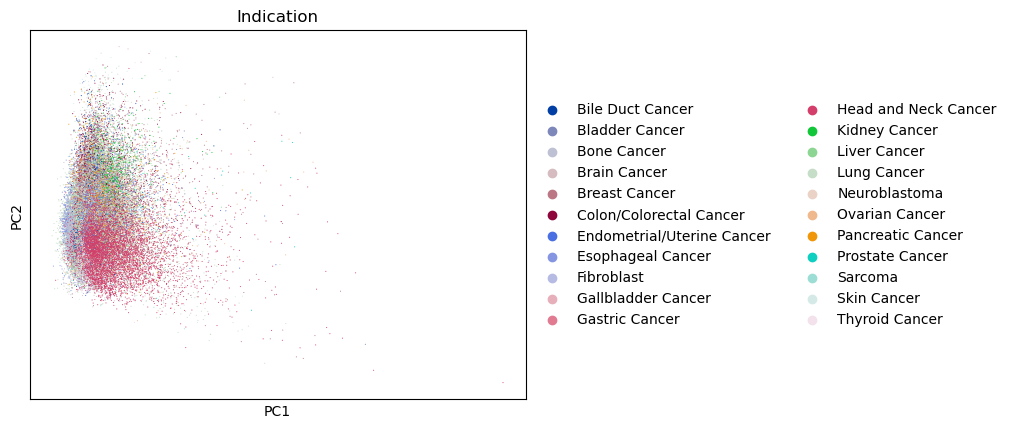

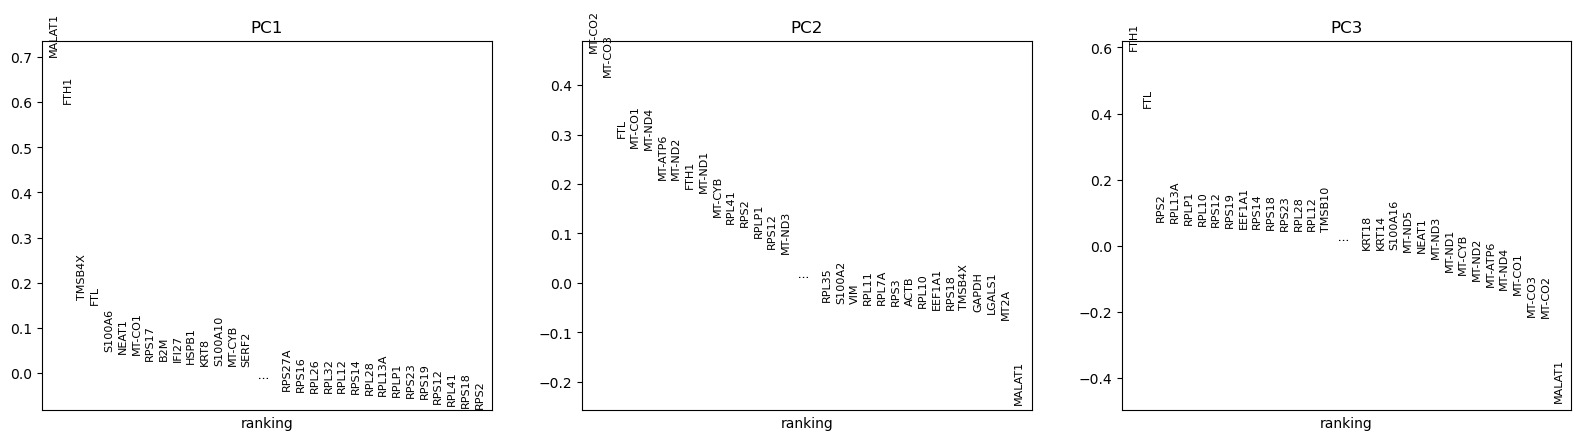

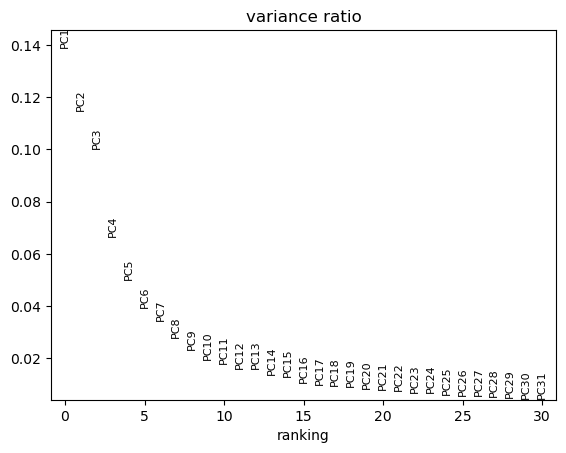

In [3]:

sc.pp.pca(adata_cpm, svd_solver='arpack')
sc.pl.pca_overview(adata_cpm, color='Indication')

- Looks much better as higher PCs contribute to variance and more genes contribute each PCs.

#### Log-normalization
-  Log-transformed expression values represent log fold changes, a standard metric for measuring expression changes.
- Reduces data skewness, making the data more closely approximate normal distribution, assumptions of many downstream analysis tools [(Luecken, et al. 2019)](https://doi.org/10.15252/msb.20188746).

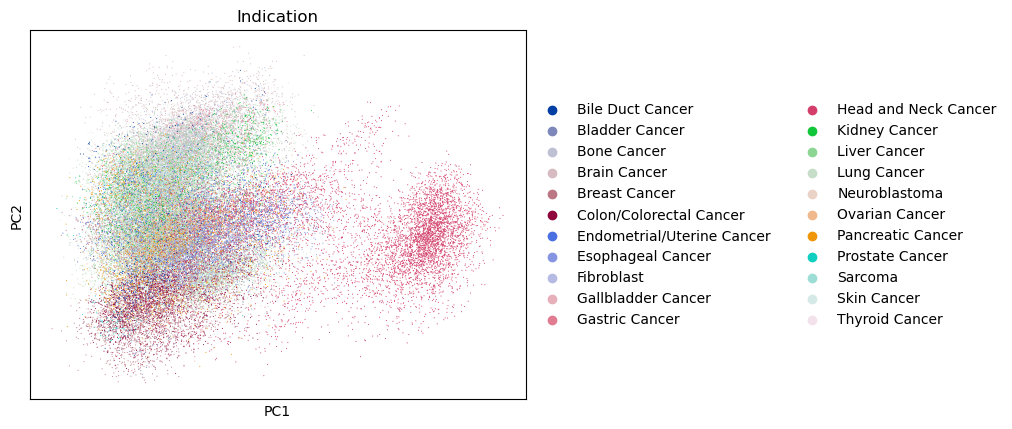

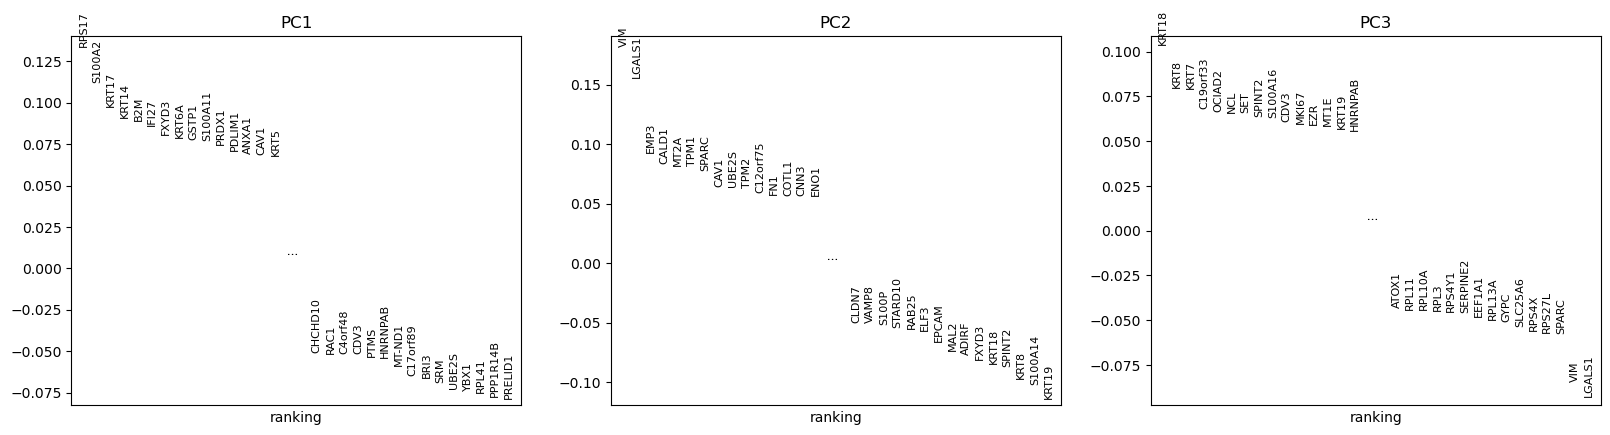

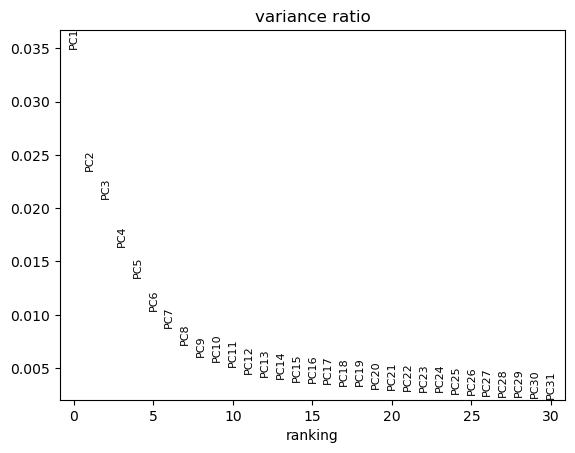

In [4]:
sc.pp.log1p(adata_cpm) #  # log-normalized data
sc.pp.pca(adata_cpm, svd_solver='arpack')
sc.pl.pca_overview(adata_cpm, color='Indication')

#### Log-normalization and Scaling 
- Centering and scaling gene expression values ensures that each gene is given equal weight in downstream analysis.
- Can reduce the dominance of a few highly expressed, differentially expressed genes [(Luecken, et al. 2019)](https://doi.org/10.15252/msb.20188746).
- Luecken et al. prefer not scale expression to retain much biological information as possible.

In [4]:
sc.pp.log1p(adata_cpm) #  # log-normalized data
sc.pp.scale(adata_cpm) # scaled data (zero mean, unit variance) - apply on log-normalized data

In [ ]:
%%time #  takes a while - might be better to run on a cluster
# sc.pp.pca(adata_cpm, svd_solver='arpack')
# sc.pl.pca_overview(adata_cpm, color='Indication')

## Pre-processing Plan
- Based on the plots, CPM normalization + log-normalization is suitable for the analysis
- By keeping the data unscaled, we can preserve the absolute differences in gene expression levels, which is crucial for identifying how HER2 and VEGF are overexpressed in different cancer types. This way, it supports the exploratory repurposing of Trastuzumab and Bevacizumab.
- Select the top 2000 differently-expressed genes from Seurat implementation which are likely to be the most informative for downstream analyses.
- Consider all PCAs (here upto 40) for gene modules and kNN graph construction for clustering,
- Construct k-nearest neighbors (k-NN) graph to connect each cell to its nearest or similar cell.
- UMAP for visualizng the data from PCs. UMAP over tSNE since it preserves both local and global structure unlike tSNE (only local).
- Leiden algorithm used to cluster cells based on the neighborhood graph, helps identify groups of similar cells, here for analysis should cluster cell with similar gene expression profiles (could be within cell line or even different cancer?). Outperformed other clustering methods as per [here](https://www.sc-best-practices.org/cellular_structure/clustering.html).

In [50]:
def BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20, resolution=None):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat')
    #sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    # k-NN graph from PCA data
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state)
    sc.tl.umap(adata, random_state=random_state)
    sc.tl.leiden(adata, random_state=random_state, resolution=resolution)
    return adata

In [51]:
adata = BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)

## Visualization


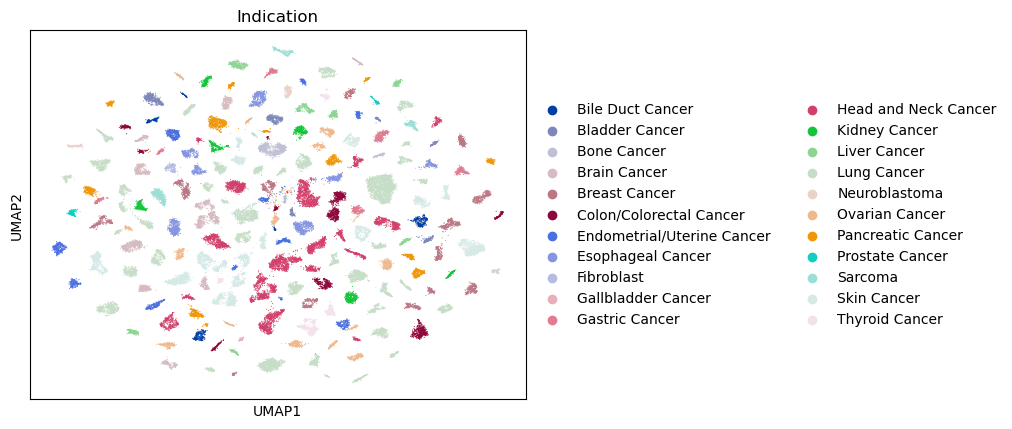

In [52]:
sc.pl.umap(adata, color=['Indication'])

- UMAP visualization by Indication, shows good separation among the cancers. 
- Clusters among different cancers show subclusters likely due to cell-line specfic differences.
- Kinker et al used t-SNE and clustered by Cell-line in Fig 1B.

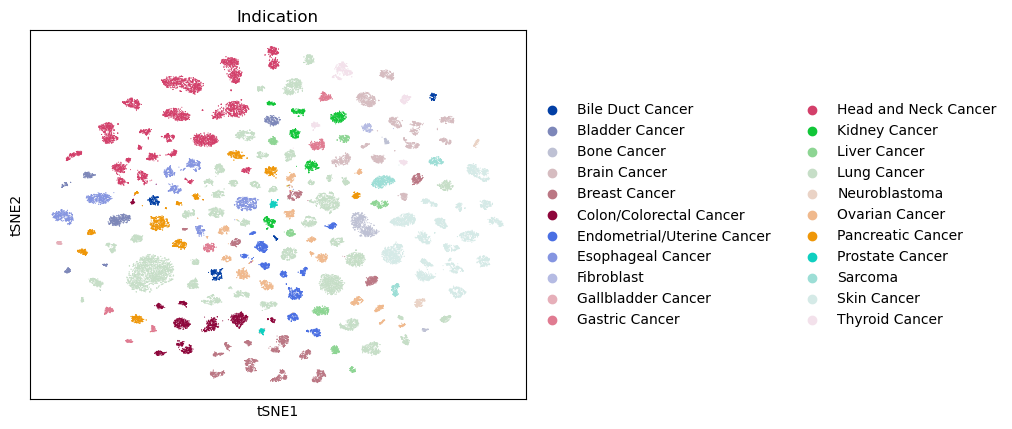

In [53]:
# plotting tSNE 
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['Indication'])  # tSNE plot

#### Recreating Figure 1B
- Kinker used tSNE to show distinct clusters for each celline, some include from Lung Cancer (e.g. NCIH2087, NCIH358), Breast cancer (EFM192A), Pancreatic cancer (PK45H).

In [54]:
# list of CellLine codes subsetted from the Kinker fig 1b
selected_cell_lines = [
    'NCIH1048', 'NCIH1568', 'NCIH1792', 'NCIH1944', 'NCIH2077', 
    'NCIH2087', 'NCIH358', 'NCIH727', 'EFM192A', 'HCC1419', 
    'KPL1', 'ZR751', 'PANC0203', 'PK45H', 'SW1990', 'KYSE520', 
    'TE6', 'HS729', 'RD', 'CL34', 'HEC59', 'KMRC3', 'SNU423', 
    'MKN7'
]

# subset  based on the selected CellLine codes
select_cell_lines_adata = adata[adata.obs['CellLine'].str.contains('|'.join(selected_cell_lines))]
#
pd.DataFrame(select_cell_lines_adata.obs['CellLine'].unique(), columns=['CellLine'])



,CellLine
0,NCIH2087_LUNG
1,HEC59_ENDOMETRIUM
2,EFM192A_BREAST
3,HS729_SOFT_TISSUE
4,SNU423_LIVER
5,KPL1_BREAST
6,NCIH727_LUNG
7,NCIH358_LUNG
8,NCIH2077_LUNG
9,KYSE520_OESOPHAGUS


/Users/kavyabanerjee/anaconda3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


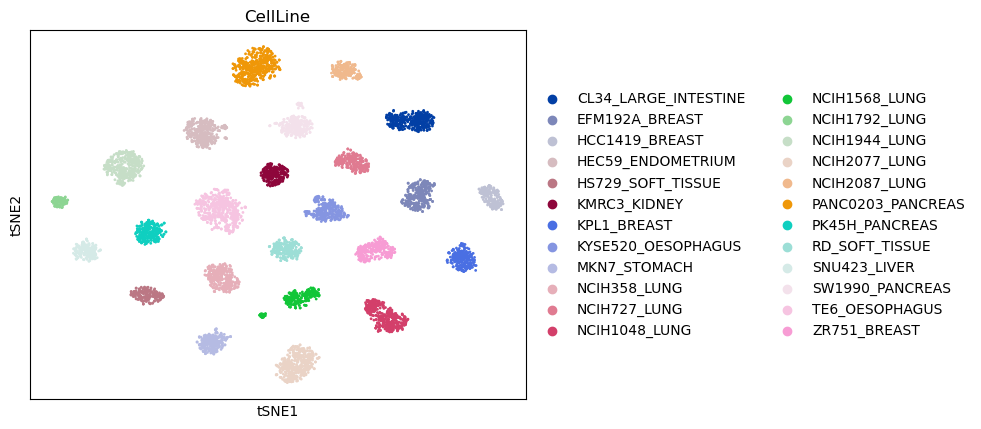

In [55]:
# re-process the data for the selected cell lines for clustering
select_cell_lines_adata = BasicScanpyPreprocessing(select_cell_lines_adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20)
sc.tl.tsne(select_cell_lines_adata)
sc.pl.tsne(select_cell_lines_adata, color=['CellLine'])  # tSNE plot by cell line

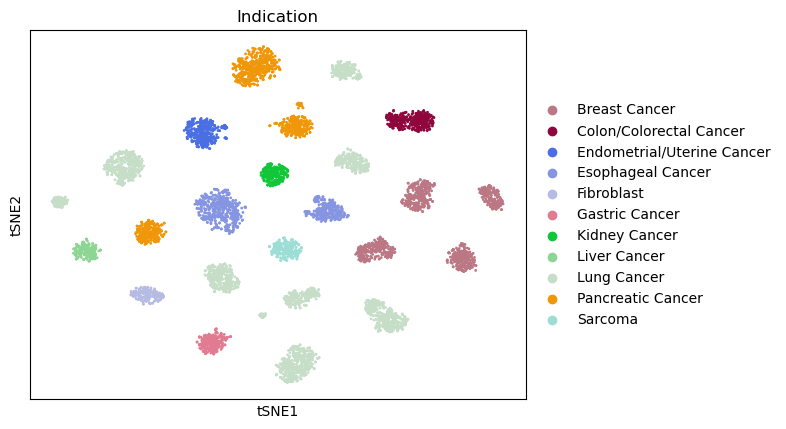

In [56]:
sc.pl.tsne(select_cell_lines_adata, color=['Indication'])  # tSNE plot by indication

- Results look consistent with the original plot, although the cluster placement as quite different. This might be due to the schochatsic behaviour.

#### Recreating Figure 2B
- Original source found distinct subclusters within few specific cell lines (e.g. NCIH2110, NCIH1299, CAK12).
- discrete clusters showed limited similarities in gene expression across different cell lines.
- Intra-tumor heterogeniety: Subpopulations were generally specific to individual cell lines, rather than common across multiple cell lines.

In [57]:
# list of CellLine codes subsetted from the Kinker fig 2b
selected_cell_lines_clusters = [
    'NCIH2110', 'NCIH1299', 'CAKI2', 'JHU006', 
]
select_cell_lines_clusters_adata = adata[adata.obs['CellLine'].str.contains('|'.join(selected_cell_lines_clusters))]
# select_cell_lines_clusters_adata.obs

In [58]:
pd.DataFrame(select_cell_lines_clusters_adata.obs['CellLine'].unique(), columns=['CellLine'])

,CellLine
0,NCIH1299_LUNG
1,NCIH2110_LUNG
2,CAKI2_KIDNEY
3,JHU006_UPPER_AERODIGESTIVE_TRACT


In [75]:
# subset and re-process the data for the selected cell lines for clustering
cell_lines = ['NCIH2110_LUNG', 'NCIH1299_LUNG', 'CAKI2_KIDNEY', 'JHU006_UPPER_AERODIGESTIVE_TRACT']

clusters_processed_data = {}

for cell_line in cell_lines:
    adata_subset = adata[adata.obs['CellLine'] == cell_line]
    clusters_processed_data[cell_line] = BasicScanpyPreprocessing(adata_subset, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20, resolution=0.5)

/Users/kavyabanerjee/anaconda3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/Users/kavyabanerjee/anaconda3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/Users/kavyabanerjee/anaconda3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/Users/kavyabanerjee/anaconda3/envs/scrnaseq/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


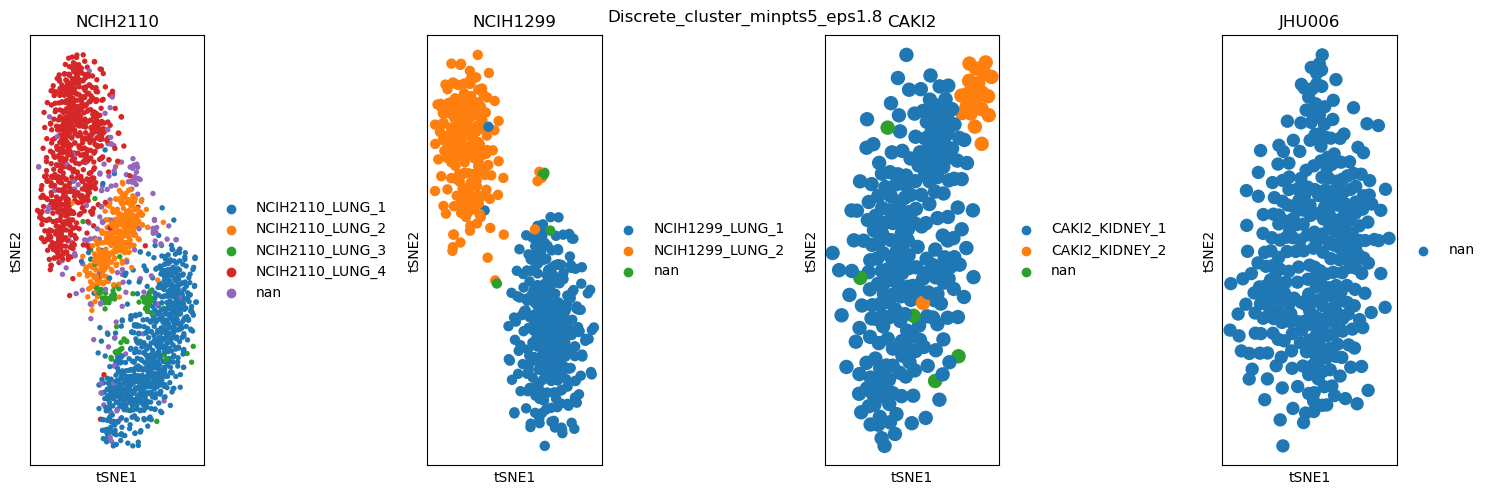

In [76]:
titles = {
    'NCIH2110_LUNG': 'NCIH2110',
    'NCIH1299_LUNG': 'NCIH1299',
    'CAKI2_KIDNEY': 'CAKI2',
    'JHU006_UPPER_AERODIGESTIVE_TRACT': 'JHU006'
}

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# loop over cell lines and plot tSNE
# based on code from paper, dbscan clustering was done by varying  minpts and eps, coloring depending on dbscan clustering
# color by dbscan clustering done with minpts=5 and eps=1.8
for idx, (cell_line, adata_processed) in enumerate(clusters_processed_data.items()):
    sc.tl.tsne(adata_processed)
    sc.pl.tsne(adata_processed, color='Discrete_cluster_minpts5_eps1.8', 
               title=titles[cell_line], show=False, ax=axes[idx])

plt.tight_layout()
fig.suptitle('Discrete_cluster_minpts5_eps1.8')
plt.show()

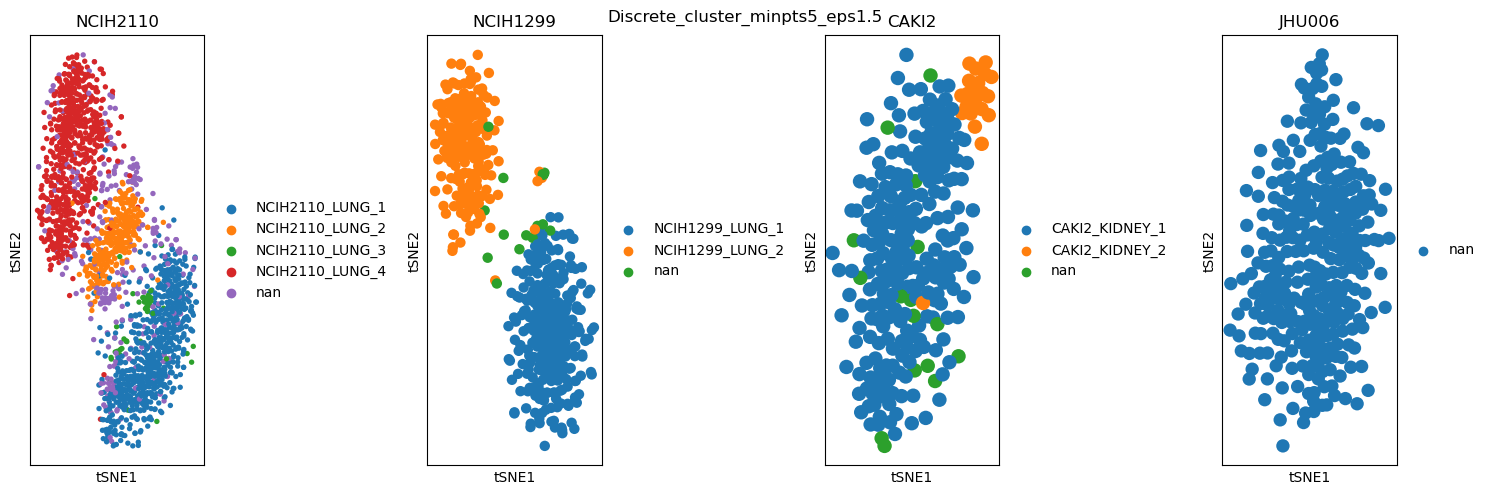

In [77]:
titles = {
    'NCIH2110_LUNG': 'NCIH2110',
    'NCIH1299_LUNG': 'NCIH1299',
    'CAKI2_KIDNEY': 'CAKI2',
    'JHU006_UPPER_AERODIGESTIVE_TRACT': 'JHU006'
}

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# loop over cell lines and plot tSNE
# based on code from paper, dbscan clustering was done by varying  minpts and eps, coloring depending on dbscan clustering
# color by dbscan clustering done with minpts=5 and eps=1.5
for idx, (cell_line, adata_processed) in enumerate(clusters_processed_data.items()):
    sc.tl.tsne(adata_processed)
    sc.pl.tsne(adata_processed, color='Discrete_cluster_minpts5_eps1.5', 
               title=titles[cell_line], show=False, ax=axes[idx])

plt.tight_layout()
fig.suptitle('Discrete_cluster_minpts5_eps1.5')
plt.show()

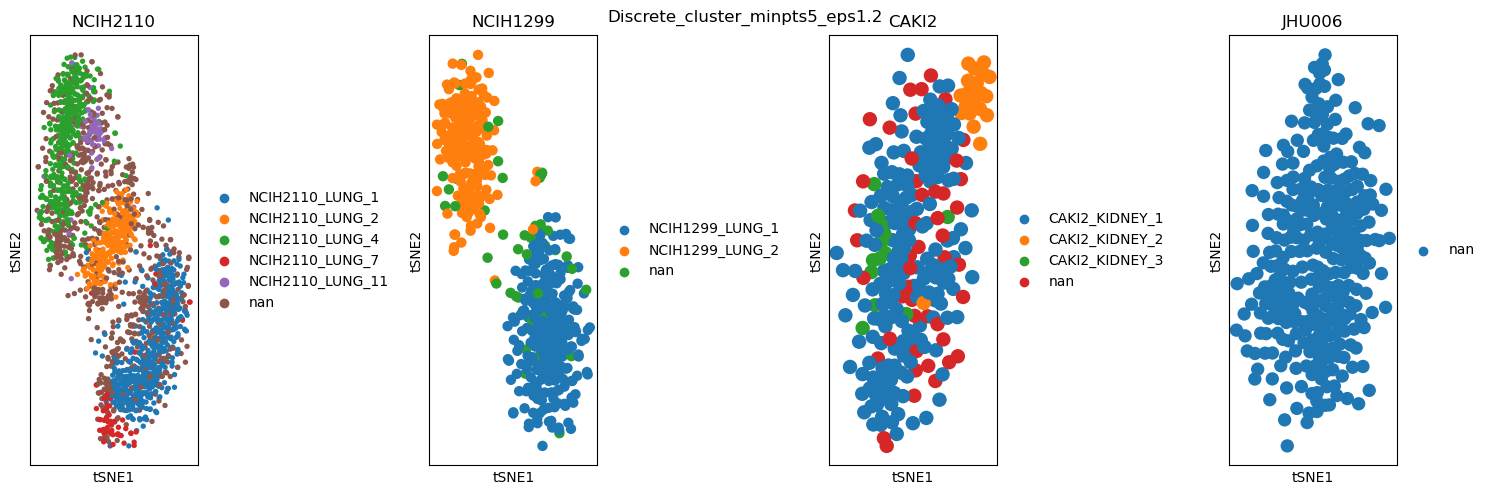

In [78]:
titles = {
    'NCIH2110_LUNG': 'NCIH2110',
    'NCIH1299_LUNG': 'NCIH1299',
    'CAKI2_KIDNEY': 'CAKI2',
    'JHU006_UPPER_AERODIGESTIVE_TRACT': 'JHU006'
}

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# loop over cell lines and plot tSNE
# based on code from paper, dbscan clustering was done by varying  minpts and eps, coloring depending on dbscan clustering
# color by dbscan clustering done with minpts=5 and eps=1.2
for idx, (cell_line, adata_processed) in enumerate(clusters_processed_data.items()):
    sc.tl.tsne(adata_processed)
    sc.pl.tsne(adata_processed, color='Discrete_cluster_minpts5_eps1.2', 
               title=titles[cell_line], show=False, ax=axes[idx])

plt.tight_layout()
fig.suptitle('Discrete_cluster_minpts5_eps1.2')
plt.show()

##### Clustering based on Leiden from Scanpy

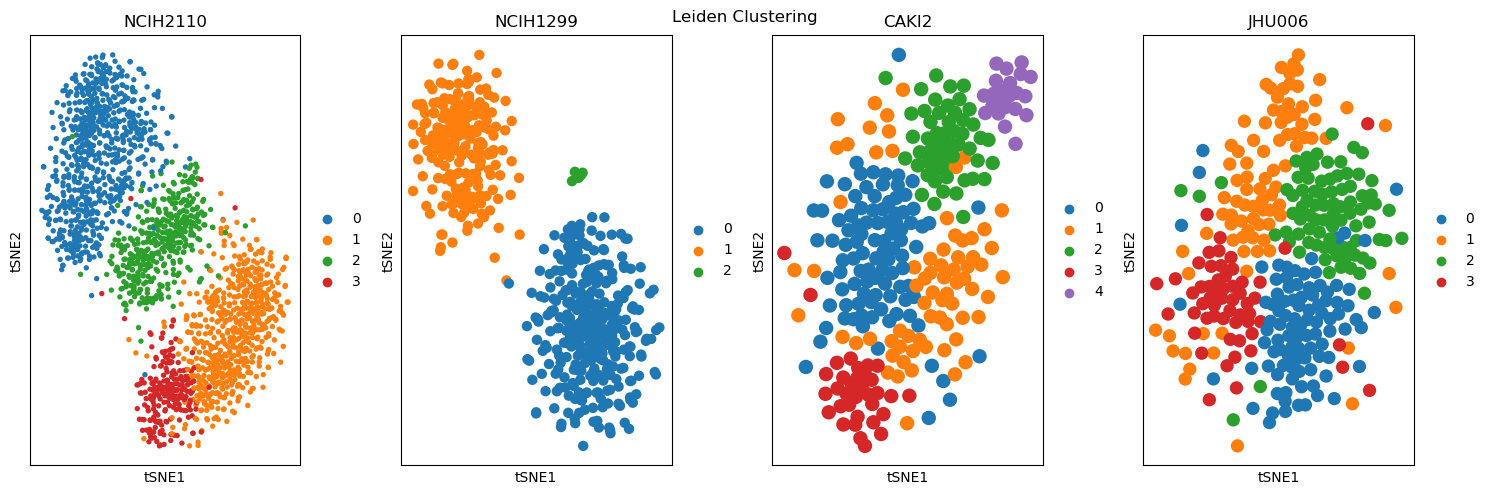

In [79]:
titles = {
    'NCIH2110_LUNG': 'NCIH2110',
    'NCIH1299_LUNG': 'NCIH1299',
    'CAKI2_KIDNEY': 'CAKI2',
    'JHU006_UPPER_AERODIGESTIVE_TRACT': 'JHU006'
}

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# loop over cell lines and plot tSNE
#  clusteinf from leiden clustering from scanpy
for idx, (cell_line, adata_processed) in enumerate(clusters_processed_data.items()):
    sc.tl.tsne(adata_processed)
    sc.pl.tsne(adata_processed, color='leiden', 
               title=titles[cell_line], show=False, ax=axes[idx])

plt.tight_layout()
fig.suptitle('Leiden Clustering')
plt.show()

- Interestingly, only CAKI2 and JHU006 cell don't correspond to the DBSCAN results. The other cell lines seem consistent. Might boil down to resolution. # need to check on this

#### Recreating Figure 2D

- Kinker et al used NMF to identify RHPs to capture continous variability in cell states on cell line which lack discrete subpopulations.
- In the paper, JHU006 cells lack distinct subpopulations but the leiden cluster as recreated above contradicts thar finding from the paper.
- Hypothesizing this might due to the leiden clusters somehow accounting for the RHPs as discrete clusters.

In [110]:
# list of CellLine codes subsetted from the Kinker fig 2d
selected_cell_lines_clusters = ['JHU006']
jhu006_cells = adata[adata.obs['CellLine'].str.contains('|'.join(selected_cell_lines_clusters))]

# create a "cell number" column that numbers each cell
jhu006_cells.obs['cell_number'] = range(1, jhu006_cells.n_obs + 1)
jhu006_cells.obs

/var/folders/8c/f79_3ppx1r59rycv6tkm4flh0000gn/T/ipykernel_4847/2406069334.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  jhu006_cells.obs['cell_number'] = range(1, jhu006_cells.n_obs + 1)


,CellLine,Pool,Indication,Genes_expressed,Discrete_cluster_minpts5_eps1.8,Discrete_cluster_minpts5_eps1.5,Discrete_cluster_minpts5_eps1.2,CNA_subclone,SkinPig_score,EMTI_score,...,p53Sen_score,EpiSen_score,StressResp_score,ProtMatu_score,ProtDegra_score,G1/S_score,G2/M_score,n_genes,leiden,cell_number
c45,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4527,nan,nan,nan,nan,-0.295,-0.152,...,0.759,2.975,0.375,0.792,1.497,-0.615,-1.144,4529,52,1
c46,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,3037,nan,nan,nan,nan,-0.028,-0.146,...,1.307,1.898,0.017,0.602,0.914,-0.969,-0.722,3039,52,2
c48,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4795,nan,nan,nan,nan,-0.159,-0.058,...,0.263,1.999,1.204,0.662,1.127,-0.273,0.183,4796,52,3
c51,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,2418,nan,nan,nan,nan,0.035,0.241,...,0.702,2.544,1.379,0.838,1.086,-1.294,-0.609,2418,52,4
c58,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6744,nan,nan,nan,nan,-0.089,0.031,...,1.062,3.543,1.187,0.723,1.019,-1.413,-1.316,6746,52,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c4722,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,3343,nan,nan,nan,nan,0.018,-0.149,...,1.583,3.850,0.539,0.473,0.544,-1.079,-1.349,3345,52,321
c4724,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6977,nan,nan,nan,nan,-0.098,-0.197,...,1.086,3.046,0.799,0.490,1.319,-0.370,0.057,6981,52,322
c4731,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6638,nan,nan,nan,nan,-0.112,-0.107,...,0.693,2.289,0.650,0.729,1.143,-0.508,0.501,6642,52,323
c4735,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4052,nan,nan,nan,nan,-0.244,0.442,...,-0.309,0.267,0.822,1.049,0.777,0.296,-0.936,4053,52,324


In [133]:
jhu006_cells =BasicScanpyPreprocessing(jhu006_cells, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20, resolution=0.5)

In [138]:
from sklearn.decomposition import NMF
from scipy.cluster.hierarchy import linkage, leaves_list

# genes of interest from the paper
genes = [
    'ATAD2', 'PCNA', 'CDK1', 'CCNB1', 'HMMR', 'CCNB2', 'MKI67', 
    'AURKA', 'COL5A1', 'AXL', 'VIM', 'SERPINE1', 'AQP3', 
    'S100A9', 'SLPI', 'SPRR1B'
]
# subset the expression data to the genes of interest
jhu006_cells_subset = jhu006_cells[:, genes]

# perform NMF on the expression data
# W mstrix: depict subpopulations or cell states
# H matrix: depict gene expression patterns
nmf = NMF(n_components=4, random_state=20)
W = nmf.fit_transform(jhu006_cells_subset.X)
H = nmf.components_

# hierarchical clustering on the NMF components (W matrix)

linkage_matrix = linkage(W, method='ward')
cell_order = leaves_list(linkage_matrix)

# reorder cells based on hierarchical clustering
jhu006_cells.obs['cell_order'] = cell_order

/Users/kavyabanerjee/anaconda3/envs/scrnaseq/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [135]:
# check the order of cells
jhu006_cells.obs

,CellLine,Pool,Indication,Genes_expressed,Discrete_cluster_minpts5_eps1.8,Discrete_cluster_minpts5_eps1.5,Discrete_cluster_minpts5_eps1.2,CNA_subclone,SkinPig_score,EMTI_score,...,EpiSen_score,StressResp_score,ProtMatu_score,ProtDegra_score,G1/S_score,G2/M_score,n_genes,leiden,cell_number,cell_order
c45,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4527,nan,nan,nan,nan,-0.295,-0.152,...,2.975,0.375,0.792,1.497,-0.615,-1.144,4529,0,1,120
c46,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,3037,nan,nan,nan,nan,-0.028,-0.146,...,1.898,0.017,0.602,0.914,-0.969,-0.722,3039,1,2,209
c48,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4795,nan,nan,nan,nan,-0.159,-0.058,...,1.999,1.204,0.662,1.127,-0.273,0.183,4796,1,3,229
c51,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,2418,nan,nan,nan,nan,0.035,0.241,...,2.544,1.379,0.838,1.086,-1.294,-0.609,2418,0,4,58
c58,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6744,nan,nan,nan,nan,-0.089,0.031,...,3.543,1.187,0.723,1.019,-1.413,-1.316,6746,0,5,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c4722,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,3343,nan,nan,nan,nan,0.018,-0.149,...,3.850,0.539,0.473,0.544,-1.079,-1.349,3345,0,321,276
c4724,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6977,nan,nan,nan,nan,-0.098,-0.197,...,3.046,0.799,0.490,1.319,-0.370,0.057,6981,0,322,23
c4731,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6638,nan,nan,nan,nan,-0.112,-0.107,...,2.289,0.650,0.729,1.143,-0.508,0.501,6642,0,323,60
c4735,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4052,nan,nan,nan,nan,-0.244,0.442,...,0.267,0.822,1.049,0.777,0.296,-0.936,4053,1,324,12


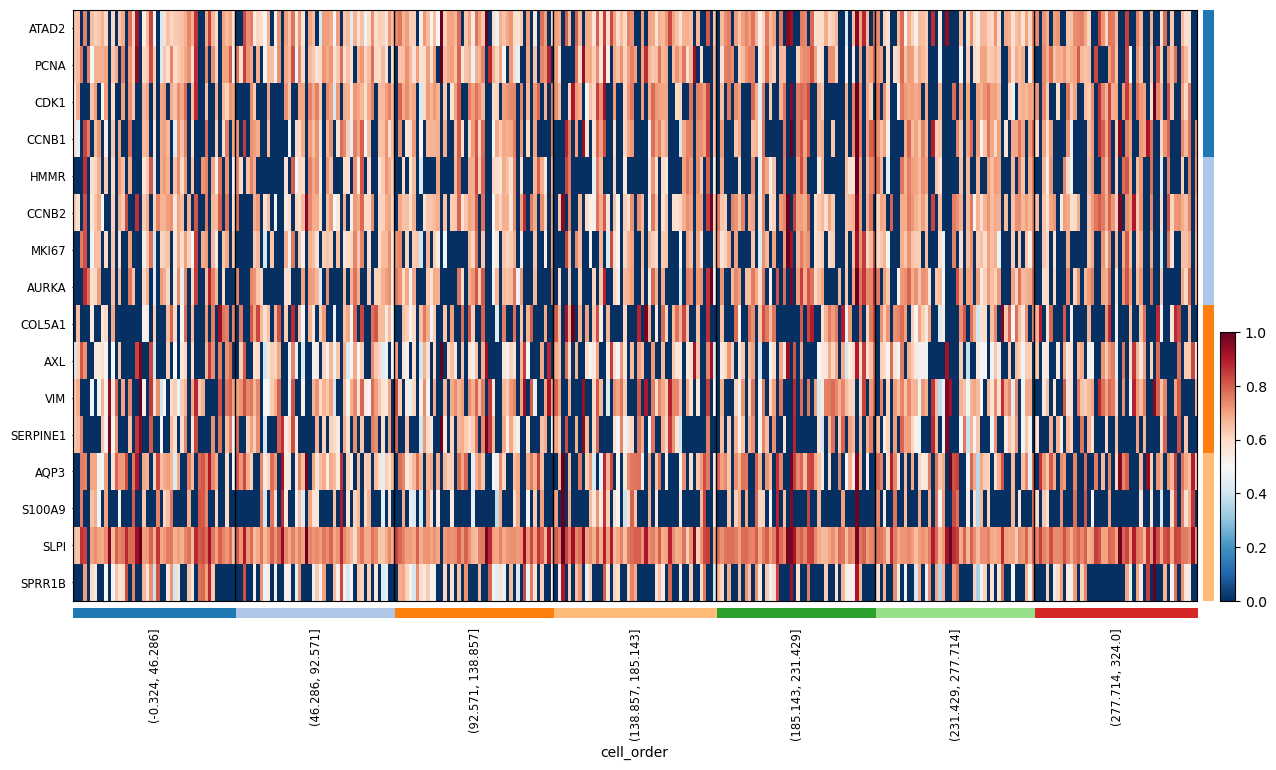

In [137]:
# list of genes from the paper
marker_genes = {
'Cell cycle G1/S': ['ATAD2', 'PCNA', 'CDK1', 'CCNB1'], 
'Cell cycle G2/M': ['HMMR', 'CCNB2', 'MKI67', 'AURKA'],
'pEMT': ['COL5A1', 'AXL', 'VIM', 'SERPINE1'],
'EpiSen': ['AQP3', 'S100A9', 'SLPI', 'SPRR1B'],
}

# heatmap of the marker genes
sc.pl.heatmap(jhu006_cells, var_names=marker_genes, groupby='cell_order',
              cmap='RdBu_r', show=True, standard_scale='var', swap_axes=True, figsize=(15, 8), tit)

plt.show()


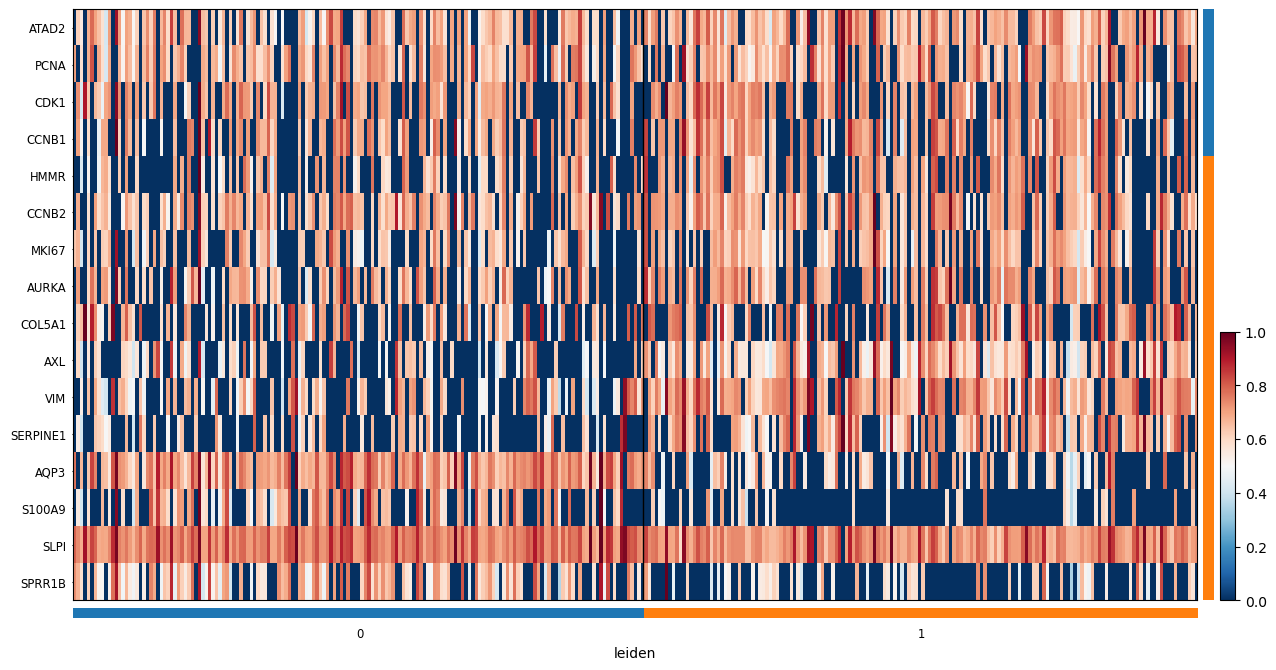

In [145]:

# heatmap of the marker genes - leiden clustering
sc.pl.heatmap(jhu006_cells, var_names=marker_genes, groupby='leiden',
              cmap='RdBu_r', show=True, standard_scale='var', swap_axes=True, figsize=(15, 8))

plt.show()

- Most patterns recapiculated from the papers, the clusters from leiden are more likely from the marker genes differential expression.